In [80]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from datetime import datetime
import pytz
import numpy as np


import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from datetime import datetime
import pytz
import numpy as np
from shapely.geometry import Point
from shapely.prepared import prep
import cartopy.io.shapereader as shpreader

In [53]:
ds = xr.open_dataset('graphcast_2024_08_03_florida_debby.nc').isel(time=slice(1,25)).sel(lat=slice(17,40)).sel(lon=slice(360-100, 360-65))
ds

<xarray.Dataset> Size: 6MB
Dimensions:  (time: 24, history: 1, lat: 93, lon: 141)
Coordinates:
  * lat      (lat) float64 744B 17.0 17.25 17.5 17.75 ... 39.25 39.5 39.75 40.0
  * lon      (lon) float64 1kB 260.0 260.2 260.5 260.8 ... 294.5 294.8 295.0
  * time     (time) datetime64[ns] 192B 2024-08-03T06:00:00 ... 2024-08-09
Dimensions without coordinates: history
Data variables:
    u10m     (time, history, lat, lon) float32 1MB ...
    v10m     (time, history, lat, lon) float32 1MB ...
    t2m      (time, history, lat, lon) float32 1MB ...
    tp06     (time, history, lat, lon) float32 1MB ...
    msl      (time, history, lat, lon) float32 1MB ...

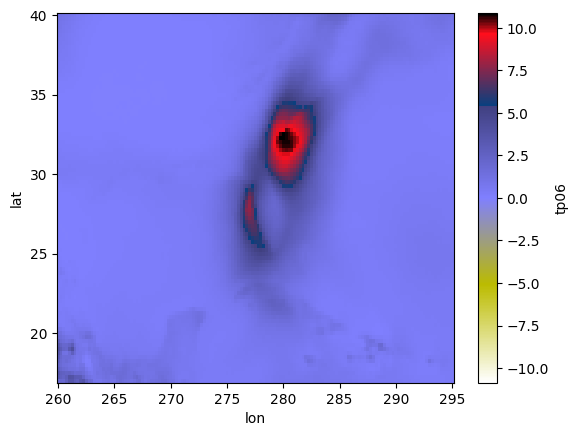

In [54]:
tp = ds.sum(dim='time').tp06 * 1000*0.0393701
tp.plot(cmap='gist_stern_r')

Text(0.5, 1.0, 'Graphcast Cumulative Precipitation from \n 2024-08-03 to 2024-08-09')

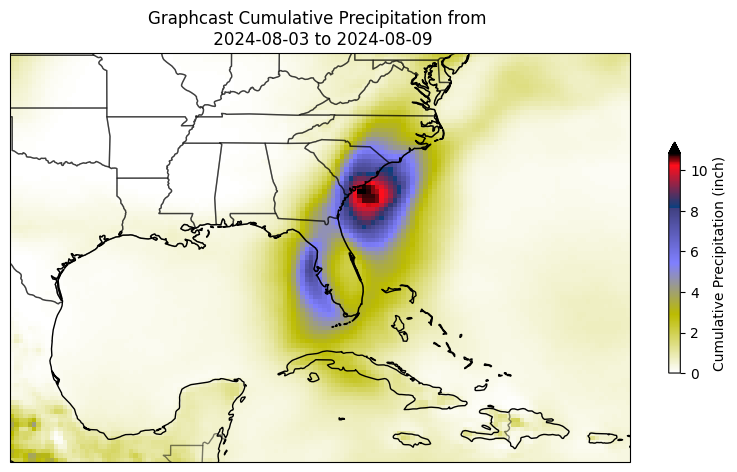

In [56]:
# Assuming ds has time dimension and coordinates
start_date = str(ds.time[0].values)[:10]
end_date = str(ds.time[-1].values)[:10]

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
plot = tp.plot(ax=ax, cmap='gist_stern_r', transform=ccrs.PlateCarree(), extend='max',
               cbar_kwargs={'shrink': 0.5, 'pad': 0.05, 'label': 'Cumulative Precipitation (inch)'}, vmin=0)

# Add country boundaries
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
# Add state boundaries (for US states)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)

# Add coastlines
ax.coastlines()

# Set title with start and end dates
ax.set_title(f'Graphcast Cumulative Precipitation from \n {start_date} to {end_date}')

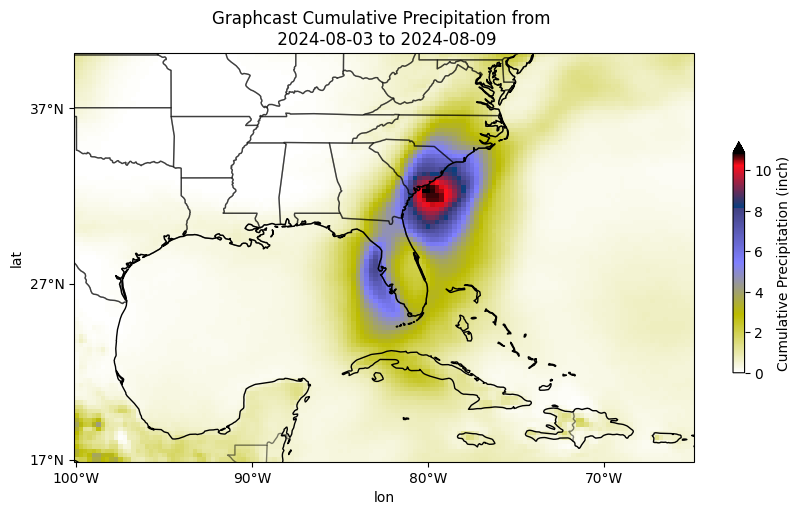

In [57]:
# Assuming ds has time dimension and coordinates
start_date = str(ds.time[0].values)[:10]
end_date = str(ds.time[-1].values)[:10]

# Convert longitudes from 0-360 to -180 to 180
tp.coords['lon'] = (tp.coords['lon'] + 180) % 360 - 180
tp = tp.sortby(tp.lon)

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
plot = tp.plot(ax=ax, cmap='gist_stern_r', transform=ccrs.PlateCarree(), extend='max',
               cbar_kwargs={'shrink': 0.5, 'pad': 0.05, 'label': 'Cumulative Precipitation (inch)'}, vmin=0)

# Add country boundaries
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
# Add state boundaries (for US states)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)

# Add coastlines
ax.coastlines()

# Set title with start and end dates
ax.set_title(f'Graphcast Cumulative Precipitation from \n {start_date} to {end_date}')

# Format x and y ticks with latitude and longitude
ax.set_xticks(range(int(tp.lon.min()), int(tp.lon.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(range(int(tp.lat.min()), int(tp.lat.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{abs(x):.0f}°W' if x < 0 else f'{x:.0f}°E'))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{abs(y):.0f}°S' if y < 0 else f'{y:.0f}°N'))


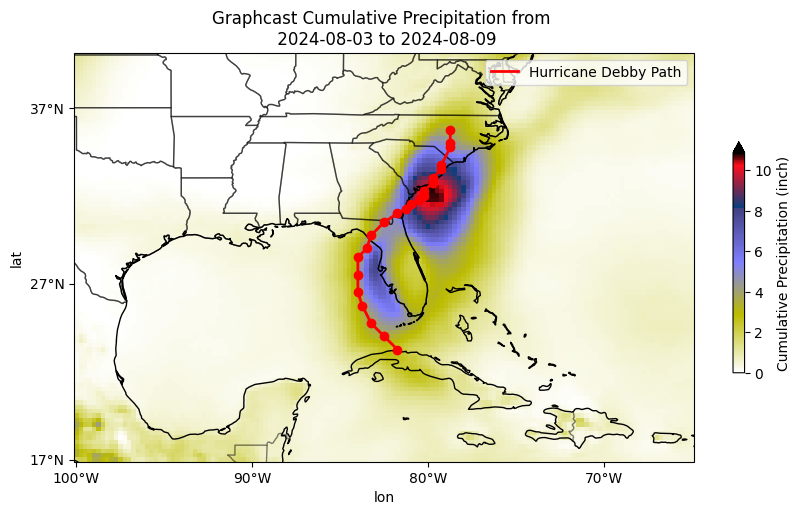

In [66]:
# Assuming ds has time dimension and coordinates
start_date = str(ds.time[0].values)[:10]
end_date = str(ds.time[-1].values)[:10]

# Convert longitudes from 0-360 to -180 to 180
tp.coords['lon'] = (tp.coords['lon'] + 180) % 360 - 180
tp = tp.sortby(tp.lon)

# Find the path of the hurricane by locating the minimum mean sea level pressure
msl = ds['msl']
hurricane_path_indices = msl.argmin(dim=['lat', 'lon'])

# Extract the lat/lon positions of the minimum MSLP
hurricane_lats = ds['lat'].isel(lat=hurricane_path_indices['lat'].values.flatten()).values
hurricane_lons = ds['lon'].isel(lon=hurricane_path_indices['lon'].values.flatten()).values

# Convert longitudes from 0-360 to -180 to 180
hurricane_lons = (hurricane_lons + 180) % 360 - 180

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
plot = tp.plot(ax=ax, cmap='gist_stern_r', transform=ccrs.PlateCarree(), extend='max',
               cbar_kwargs={'shrink': 0.5, 'pad': 0.05, 'label': 'Cumulative Precipitation (inch)'}, vmin=0)

# Add country boundaries
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
# Add state boundaries (for US states)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)

# Add coastlines
ax.coastlines()

# Plot the hurricane path
ax.plot(hurricane_lons[1:], hurricane_lats[1:], 'r-', linewidth=2, transform=ccrs.PlateCarree(), label='Hurricane Debby Path')
ax.plot(hurricane_lons[1:], hurricane_lats[1:], 'ro', transform=ccrs.PlateCarree())  # Plot points for each time step

# Add legend
ax.legend()

# Set title with start and end dates
ax.set_title(f'Graphcast Cumulative Precipitation from \n {start_date} to {end_date}')

# Format x and y ticks with latitude and longitude
ax.set_xticks(range(int(tp.lon.min()), int(tp.lon.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(range(int(tp.lat.min()), int(tp.lat.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{abs(x):.0f}°W' if x < 0 else f'{x:.0f}°E'))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{abs(y):.0f}°S' if y < 0 else f'{y:.0f}°N'))


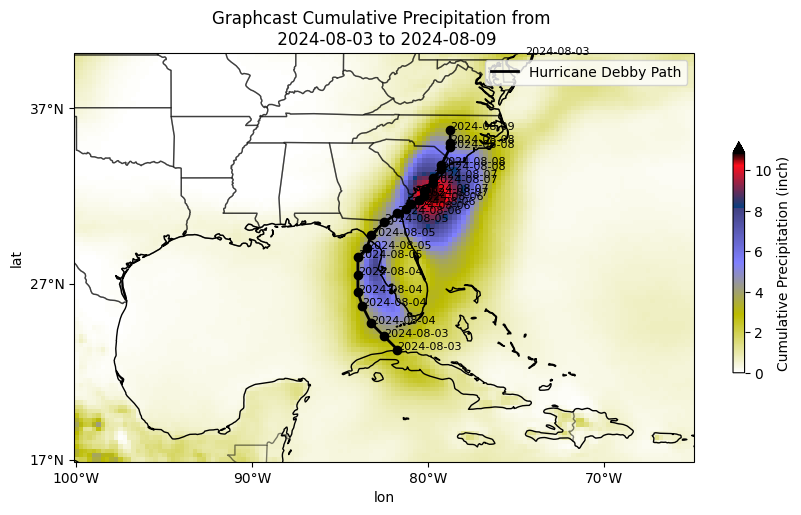

In [69]:
# Assuming ds has time dimension and coordinates
start_date = str(ds.time[0].values)[:10]
end_date = str(ds.time[-1].values)[:10]

# Convert longitudes from 0-360 to -180 to 180
tp.coords['lon'] = (tp.coords['lon'] + 180) % 360 - 180
tp = tp.sortby(tp.lon)

# Find the path of the hurricane by locating the minimum mean sea level pressure
msl = ds['msl']
hurricane_path_indices = msl.argmin(dim=['lat', 'lon'])

# Extract the lat/lon positions of the minimum MSLP
hurricane_lats = ds['lat'].isel(lat=hurricane_path_indices['lat'].values.flatten()).values
hurricane_lons = ds['lon'].isel(lon=hurricane_path_indices['lon'].values.flatten()).values

# Convert longitudes from 0-360 to -180 to 180
hurricane_lons = (hurricane_lons + 180) % 360 - 180

# Extract the time values for annotations
hurricane_dates = ds['time'].values

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
plot = tp.plot(ax=ax, cmap='gist_stern_r', transform=ccrs.PlateCarree(), extend='max',
               cbar_kwargs={'shrink': 0.5, 'pad': 0.05, 'label': 'Cumulative Precipitation (inch)'}, vmin=0)

# Add country boundaries
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
# Add state boundaries (for US states)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)

# Add coastlines
ax.coastlines()

# # Plot the hurricane path
# ax.plot(hurricane_lons, hurricane_lats, 'k-', linewidth=2, transform=ccrs.PlateCarree(), label='Hurricane Path')
# ax.plot(hurricane_lons, hurricane_lats, 'ko', transform=ccrs.PlateCarree())  # Plot points for each time step

# Plot the hurricane path
ax.plot(hurricane_lons[1:], hurricane_lats[1:], 'k-', linewidth=2, transform=ccrs.PlateCarree(), label='Hurricane Debby Path')
ax.plot(hurricane_lons[1:], hurricane_lats[1:], 'ko', transform=ccrs.PlateCarree())  # Plot points for each time step


# Annotate dates on the hurricane path
for lon, lat, date in zip(hurricane_lons, hurricane_lats, hurricane_dates):
    ax.text(lon, lat, str(date)[:10], fontsize=8, transform=ccrs.PlateCarree())

# Add legend
ax.legend()

# Set title with start and end dates
ax.set_title(f'Graphcast Cumulative Precipitation from \n {start_date} to {end_date}')

# Format x and y ticks with latitude and longitude
ax.set_xticks(range(int(tp.lon.min()), int(tp.lon.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(range(int(tp.lat.min()), int(tp.lat.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{abs(x):.0f}°W' if x < 0 else f'{x:.0f}°E'))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{abs(y):.0f}°S' if y < 0 else f'{y:.0f}°N'))


/tmp/ipykernel_1653505/2451692676.py:46: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  utc_time = datetime.utcfromtimestamp((date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))


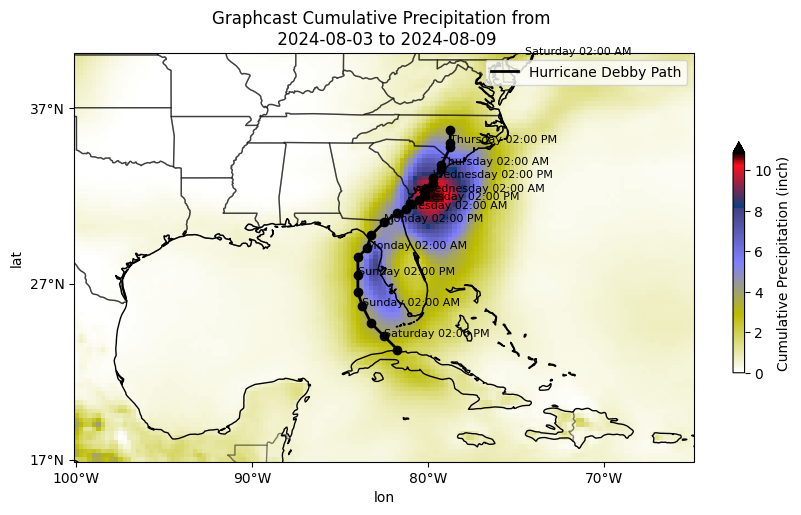

In [73]:
# Assuming ds has time dimension and coordinates
start_date = str(ds.time[0].values)[:10]
end_date = str(ds.time[-1].values)[:10]

# Convert longitudes from 0-360 to -180 to 180
tp.coords['lon'] = (tp.coords['lon'] + 180) % 360 - 180
tp = tp.sortby(tp.lon)

# Find the path of the hurricane by locating the minimum mean sea level pressure
msl = ds['msl']
hurricane_path_indices = msl.argmin(dim=['lat', 'lon'])

# Extract the lat/lon positions of the minimum MSLP
hurricane_lats = ds['lat'].isel(lat=hurricane_path_indices['lat'].values.flatten()).values
hurricane_lons = ds['lon'].isel(lon=hurricane_path_indices['lon'].values.flatten()).values

# Convert longitudes from 0-360 to -180 to 180
hurricane_lons = (hurricane_lons + 180) % 360 - 180

# Extract the time values for annotations
hurricane_dates = ds['time'].values

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
plot = tp.plot(ax=ax, cmap='gist_stern_r', transform=ccrs.PlateCarree(), extend='max',
               cbar_kwargs={'shrink': 0.5, 'pad': 0.05, 'label': 'Cumulative Precipitation (inch)'}, vmin=0)

# Add country boundaries
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
# Add state boundaries (for US states)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)

# Add coastlines
ax.coastlines()

# Plot the hurricane path
ax.plot(hurricane_lons[1:], hurricane_lats[1:], 'k-', linewidth=2, transform=ccrs.PlateCarree(), label='Hurricane Debby Path')
ax.plot(hurricane_lons[1:], hurricane_lats[1:], 'ko', transform=ccrs.PlateCarree())  # Plot points for each time step

# Annotate dates on the hurricane path
florida_tz = pytz.timezone('America/New_York')

for lon, lat, date in zip(hurricane_lons[::2], hurricane_lats[::2], hurricane_dates[::2]):
    utc_time = datetime.utcfromtimestamp((date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
    local_time = utc_time.replace(tzinfo=pytz.utc).astimezone(florida_tz)
    time_str = local_time.strftime('%A %I:%M %p')
    ax.text(lon, lat, time_str, fontsize=8, transform=ccrs.PlateCarree())

# Add legend
ax.legend()

# Set title with start and end dates
ax.set_title(f'Graphcast Cumulative Precipitation from \n {start_date} to {end_date}')

# Format x and y ticks with latitude and longitude
ax.set_xticks(range(int(tp.lon.min()), int(tp.lon.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(range(int(tp.lat.min()), int(tp.lat.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{abs(x):.0f}°W' if x < 0 else f'{x:.0f}°E'))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{abs(y):.0f}°S' if y < 0 else f'{y:.0f}°N'))


/tmp/ipykernel_1653505/2888386649.py:65: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  utc_time = datetime.utcfromtimestamp((date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))


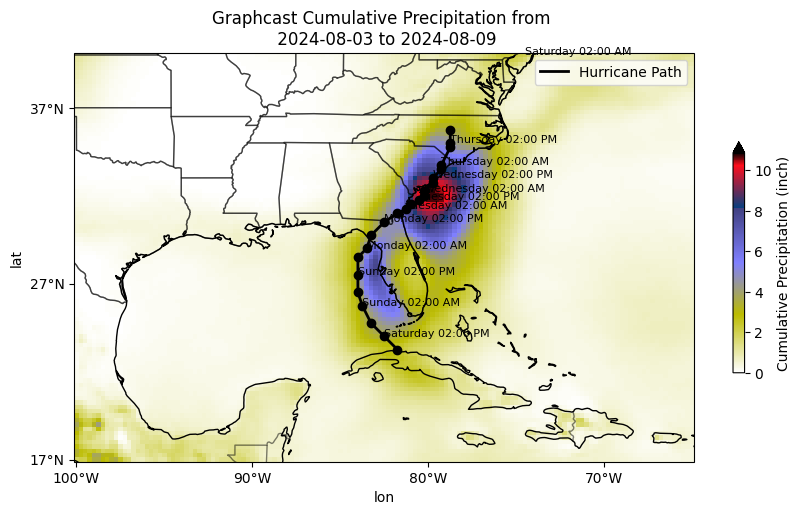

In [74]:
# Assuming ds has time dimension and coordinates
start_date = str(ds.time[0].values)[:10]
end_date = str(ds.time[-1].values)[:10]

# Convert longitudes from 0-360 to -180 to 180
tp.coords['lon'] = (tp.coords['lon'] + 180) % 360 - 180
tp = tp.sortby(tp.lon)

# Find the path of the hurricane by locating the minimum mean sea level pressure
msl = ds['msl']
hurricane_path_indices = msl.argmin(dim=['lat', 'lon'])

# Extract the lat/lon positions of the minimum MSLP
hurricane_lats = ds['lat'].isel(lat=hurricane_path_indices['lat'].values.flatten()).values
hurricane_lons = ds['lon'].isel(lon=hurricane_path_indices['lon'].values.flatten()).values

# Convert longitudes from 0-360 to -180 to 180
hurricane_lons = (hurricane_lons + 180) % 360 - 180

# Extract the time values for annotations
hurricane_dates = ds['time'].values

# Function to check if a point is on land
def is_on_land(lon, lat):
    import cartopy.io.shapereader as shpreader
    from shapely.geometry import Point
    from shapely.prepared import prep

    land_shp = shpreader.natural_earth(resolution='110m', category='physical', name='land')
    land_geom = list(shpreader.Reader(land_shp).geometries())
    land = prep(land_geom[0])
    
    point = Point(lon, lat)
    return land.contains(point)

# Find the landfall location
landfall_lon, landfall_lat = None, None
for lon, lat in zip(hurricane_lons, hurricane_lats):
    if is_on_land(lon, lat):
        landfall_lon, landfall_lat = lon, lat
        break

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
plot = tp.plot(ax=ax, cmap='gist_stern_r', transform=ccrs.PlateCarree(), extend='max',
               cbar_kwargs={'shrink': 0.5, 'pad': 0.05, 'label': 'Cumulative Precipitation (inch)'}, vmin=0)

# Add country boundaries
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
# Add state boundaries (for US states)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)

# Add coastlines
ax.coastlines()

# Plot the hurricane path
ax.plot(hurricane_lons[1:], hurricane_lats[1:], 'k-', linewidth=2, transform=ccrs.PlateCarree(), label='Hurricane Path')
ax.plot(hurricane_lons[1:], hurricane_lats[1:], 'ko', transform=ccrs.PlateCarree())  # Plot points for each time step

# Annotate dates on the hurricane path
florida_tz = pytz.timezone('America/New_York')
for lon, lat, date in zip(hurricane_lons[::2], hurricane_lats[::2], hurricane_dates[::2]):
    utc_time = datetime.utcfromtimestamp((date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
    local_time = utc_time.replace(tzinfo=pytz.utc).astimezone(florida_tz)
    time_str = local_time.strftime('%A %I:%M %p')
    ax.text(lon, lat, time_str, fontsize=8, transform=ccrs.PlateCarree())

# Mark the landfall location
if landfall_lon is not None and landfall_lat is not None:
    ax.plot(landfall_lon, landfall_lat, 'bo', markersize=10, transform=ccrs.PlateCarree(), label='Landfall')

# Add legend
ax.legend()

# Set title with start and end dates
ax.set_title(f'Graphcast Cumulative Precipitation from \n {start_date} to {end_date}')

# Format x and y ticks with latitude and longitude
ax.set_xticks(range(int(tp.lon.min()), int(tp.lon.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(range(int(tp.lat.min()), int(tp.lat.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{abs(x):.0f}°W' if x < 0 else f'{x:.0f}°E'))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{abs(y):.0f}°S' if y < 0 else f'{y:.0f}°N'))


In [82]:
print(landfall_lon, landfall_lat)

-74.5 40.0


In [85]:
# Prepare the land geometry for high-resolution check
land_shp = shpreader.natural_earth(resolution='10m', category='physical', name='land')
land_geom = list(shpreader.Reader(land_shp).geometries())
land = prep(land_geom[0])

# Function to check if a point is on land
def is_on_land(lon, lat):
    point = Point(lon, lat)
    return land.contains(point)

# Function to interpolate points between two coordinates
def interpolate_points(lon1, lat1, lon2, lat2, num_points=1000000):
    lons = np.linspace(lon1, lon2, num_points)
    lats = np.linspace(lat1, lat2, num_points)
    return zip(lons, lats)

# Find the landfall location with interpolation
landfall_lon, landfall_lat = None, None
for lon1, lat1, lon2, lat2 in zip(hurricane_lons[1:], hurricane_lats[1:], hurricane_lons[1:], hurricane_lats[1:]):
    for lon, lat in interpolate_points(lon1, lat1, lon2, lat2):
        if is_on_land(lon, lat):
            landfall_lon, landfall_lat = lon, lat
            print('Landfall location: ', landfall_lon, landfall_lat)
            break
    if landfall_lon is not None and landfall_lat is not None:
        break

Landfall location:  -83.25 29.75


In [88]:
# Extract the time values for annotations
hurricane_dates = ds['time'].values[1:]

hurricane_lons_ = hurricane_lons[1:]
hurricane_lats_ = hurricane_lats[1:]


# Prepare the land geometry for high-resolution check
land_shp = shpreader.natural_earth(resolution='10m', category='physical', name='land')
land_geom = list(shpreader.Reader(land_shp).geometries())
land = prep(land_geom[0])

# Function to check if a point is on land
def is_on_land(lon, lat):
    point = Point(lon, lat)
    return land.contains(point)

# Function to interpolate points between two coordinates
def interpolate_points(lon1, lat1, lon2, lat2, num_points=1000000):
    lons = np.linspace(lon1, lon2, num_points)
    lats = np.linspace(lat1, lat2, num_points)
    return zip(lons, lats)

# Find the landfall location with interpolation
landfall_lon, landfall_lat, landfall_time = None, None, None
for i in range(len(hurricane_lons_) - 1):
    lon1, lat1, lon2, lat2 = hurricane_lons_[i], hurricane_lats_[i], hurricane_lons_[i+1], hurricane_lats_[i+1]
    for j, (lon, lat) in enumerate(interpolate_points(lon1, lat1, lon2, lat2)):
        if is_on_land(lon, lat):
            landfall_lon, landfall_lat = lon, lat
            time_diff = hurricane_dates[i+1] - hurricane_dates[i]
            landfall_time = hurricane_dates[i] + j * time_diff / 1000000
            print('Landfall location: ', landfall_lon, landfall_lat)
            print('Landfall time (UTC): ', landfall_time)
            break
    if landfall_lon is not None and landfall_lat is not None:
        break


Landfall location:  -83.33663458663459 29.49009624009624
Landfall time (UTC):  2024-08-05T04:47:48.013526291


In [89]:
# Convert landfall time to Florida time
if landfall_time is not None:
    landfall_time_utc = datetime.utcfromtimestamp((landfall_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
    florida_tz = pytz.timezone('America/New_York')
    landfall_time_local = landfall_time_utc.replace(tzinfo=pytz.utc).astimezone(florida_tz)
    print('Landfall time (Florida time): ', landfall_time_local.strftime('%A %I:%M %p'))


Landfall time (Florida time):  Monday 12:47 AM


/tmp/ipykernel_1653505/885254558.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  landfall_time_utc = datetime.utcfromtimestamp((landfall_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))


In [90]:
ds = xr.open_dataset('graphcast_2024_08_04_florida_debby.nc').isel(time=slice(1,25)).sel(lat=slice(17,40)).sel(lon=slice(360-100, 360-65))
ds

<xarray.Dataset> Size: 6MB
Dimensions:  (time: 24, history: 1, lat: 93, lon: 141)
Coordinates:
  * lat      (lat) float64 744B 17.0 17.25 17.5 17.75 ... 39.25 39.5 39.75 40.0
  * lon      (lon) float64 1kB 260.0 260.2 260.5 260.8 ... 294.5 294.8 295.0
  * time     (time) datetime64[ns] 192B 2024-08-04T06:00:00 ... 2024-08-10
Dimensions without coordinates: history
Data variables:
    u10m     (time, history, lat, lon) float32 1MB ...
    v10m     (time, history, lat, lon) float32 1MB ...
    t2m      (time, history, lat, lon) float32 1MB ...
    tp06     (time, history, lat, lon) float32 1MB ...
    msl      (time, history, lat, lon) float32 1MB ...

# 4 Aug 2024 

/tmp/ipykernel_1653505/2109760818.py:65: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  utc_time = datetime.utcfromtimestamp((date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
/home/ms86336/anaconda3/envs/noaa_aorc/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:525: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


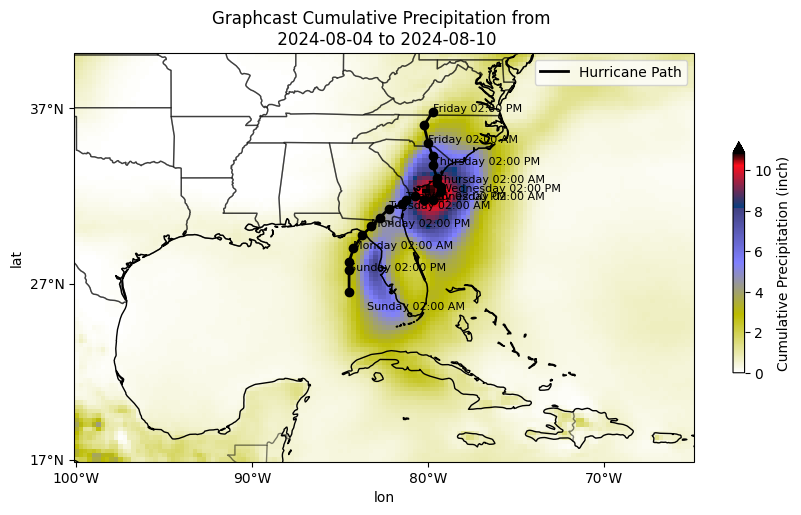

In [92]:
# Assuming ds has time dimension and coordinates
start_date = str(ds.time[0].values)[:10]
end_date = str(ds.time[-1].values)[:10]

# Convert longitudes from 0-360 to -180 to 180
tp.coords['lon'] = (tp.coords['lon'] + 180) % 360 - 180
tp = tp.sortby(tp.lon)

# Find the path of the hurricane by locating the minimum mean sea level pressure
msl = ds['msl']
hurricane_path_indices = msl.argmin(dim=['lat', 'lon'])

# Extract the lat/lon positions of the minimum MSLP
hurricane_lats = ds['lat'].isel(lat=hurricane_path_indices['lat'].values.flatten()).values
hurricane_lons = ds['lon'].isel(lon=hurricane_path_indices['lon'].values.flatten()).values

# Convert longitudes from 0-360 to -180 to 180
hurricane_lons = (hurricane_lons + 180) % 360 - 180

# Extract the time values for annotations
hurricane_dates = ds['time'].values

# Function to check if a point is on land
def is_on_land(lon, lat):
    import cartopy.io.shapereader as shpreader
    from shapely.geometry import Point
    from shapely.prepared import prep

    land_shp = shpreader.natural_earth(resolution='110m', category='physical', name='land')
    land_geom = list(shpreader.Reader(land_shp).geometries())
    land = prep(land_geom[0])
    
    point = Point(lon, lat)
    return land.contains(point)

# Find the landfall location
landfall_lon, landfall_lat = None, None
for lon, lat in zip(hurricane_lons, hurricane_lats):
    if is_on_land(lon, lat):
        landfall_lon, landfall_lat = lon, lat
        break

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the data
plot = tp.plot(ax=ax, cmap='gist_stern_r', transform=ccrs.PlateCarree(), extend='max',
               cbar_kwargs={'shrink': 0.5, 'pad': 0.05, 'label': 'Cumulative Precipitation (inch)'}, vmin=0)

# Add country boundaries
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
# Add state boundaries (for US states)
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)

# Add coastlines
ax.coastlines()

# Plot the hurricane path
ax.plot(hurricane_lons[1:-1], hurricane_lats[1:-1], 'k-', linewidth=2, transform=ccrs.PlateCarree(), label='Hurricane Path')
ax.plot(hurricane_lons[1:-1], hurricane_lats[1:-1], 'ko', transform=ccrs.PlateCarree())  # Plot points for each time step

# Annotate dates on the hurricane path
florida_tz = pytz.timezone('America/New_York')
for lon, lat, date in zip(hurricane_lons[::2], hurricane_lats[::2], hurricane_dates[::2]):
    utc_time = datetime.utcfromtimestamp((date - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
    local_time = utc_time.replace(tzinfo=pytz.utc).astimezone(florida_tz)
    time_str = local_time.strftime('%A %I:%M %p')
    ax.text(lon, lat, time_str, fontsize=8, transform=ccrs.PlateCarree())

# Mark the landfall location
if landfall_lon is not None and landfall_lat is not None:
    ax.plot(landfall_lon, landfall_lat, 'bo', markersize=10, transform=ccrs.PlateCarree(), label='Landfall')

# Add legend
ax.legend()

# Set title with start and end dates
ax.set_title(f'Graphcast Cumulative Precipitation from \n {start_date} to {end_date}')

# Format x and y ticks with latitude and longitude
ax.set_xticks(range(int(tp.lon.min()), int(tp.lon.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.set_yticks(range(int(tp.lat.min()), int(tp.lat.max()) + 1, 10), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{abs(x):.0f}°W' if x < 0 else f'{x:.0f}°E'))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{abs(y):.0f}°S' if y < 0 else f'{y:.0f}°N'))


In [93]:
# Extract the time values for annotations
hurricane_dates = ds['time'].values[1:]

hurricane_lons_ = hurricane_lons[1:]
hurricane_lats_ = hurricane_lats[1:]


# Prepare the land geometry for high-resolution check
land_shp = shpreader.natural_earth(resolution='10m', category='physical', name='land')
land_geom = list(shpreader.Reader(land_shp).geometries())
land = prep(land_geom[0])

# Function to check if a point is on land
def is_on_land(lon, lat):
    point = Point(lon, lat)
    return land.contains(point)

# Function to interpolate points between two coordinates
def interpolate_points(lon1, lat1, lon2, lat2, num_points=1000000):
    lons = np.linspace(lon1, lon2, num_points)
    lats = np.linspace(lat1, lat2, num_points)
    return zip(lons, lats)

# Find the landfall location with interpolation
landfall_lon, landfall_lat, landfall_time = None, None, None
for i in range(len(hurricane_lons_) - 1):
    lon1, lat1, lon2, lat2 = hurricane_lons_[i], hurricane_lats_[i], hurricane_lons_[i+1], hurricane_lats_[i+1]
    for j, (lon, lat) in enumerate(interpolate_points(lon1, lat1, lon2, lat2)):
        if is_on_land(lon, lat):
            landfall_lon, landfall_lat = lon, lat
            time_diff = hurricane_dates[i+1] - hurricane_dates[i]
            landfall_time = hurricane_dates[i] + j * time_diff / 1000000
            print('Landfall location: ', landfall_lon, landfall_lat)
            print('Landfall time (UTC): ', landfall_time)
            break
    if landfall_lon is not None and landfall_lat is not None:
        break


Landfall location:  -83.63053188053188 29.86946811946812
Landfall time (UTC):  2024-08-05T13:26:01.017600000


In [94]:
# Convert landfall time to Florida time
if landfall_time is not None:
    landfall_time_utc = datetime.utcfromtimestamp((landfall_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
    florida_tz = pytz.timezone('America/New_York')
    landfall_time_local = landfall_time_utc.replace(tzinfo=pytz.utc).astimezone(florida_tz)
    print('Landfall time (Florida time): ', landfall_time_local.strftime('%A %I:%M %p'))


Landfall time (Florida time):  Monday 09:26 AM


/tmp/ipykernel_1653505/885254558.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  landfall_time_utc = datetime.utcfromtimestamp((landfall_time - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's'))
